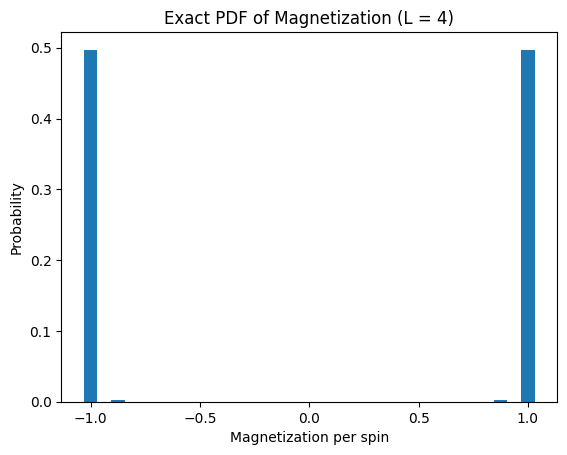

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Parameters
L = 4
J = 1
B = 0
T = 1.0

def energy_config(config, J, B):

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])
    # Use periodic boundaries via 'wrap'
    neighbor_sum = convolve2d(config, kernel, mode='same', boundary='wrap')
    E = -0.5 * J * np.sum(config * neighbor_sum) - B * np.sum(config)
    return E

def magnetization(config):
    return np.sum(config) / config.size

def enumerate_configs(L):

    num_configs = 2**(L*L)
    configs = []
    for i in range(num_configs):
        bits = format(i, '0{}b'.format(L*L))
        config = np.array([1 if bit=='1' else -1 for bit in bits]).reshape(L, L)
        configs.append(config)
    return np.array(configs)

configs = enumerate_configs(L)
energies = np.array([energy_config(c, J, B) for c in configs])
weights = np.exp(-energies/T)
Z = np.sum(weights)

mag_dict = dict()
for config, weight in zip(configs, weights):
    m = magnetization(config)
    mag_dict[m] = mag_dict.get(m, 0) + weight
for m in mag_dict:
    mag_dict[m] /= Z

# Plot the probability distribution of magnetization
plt.bar(list(mag_dict.keys()), list(mag_dict.values()), width=1/(L*L))
plt.xlabel('Magnetization per spin')
plt.ylabel('Probability')
plt.title('Exact PDF of Magnetization (L = 4)')
plt.show()


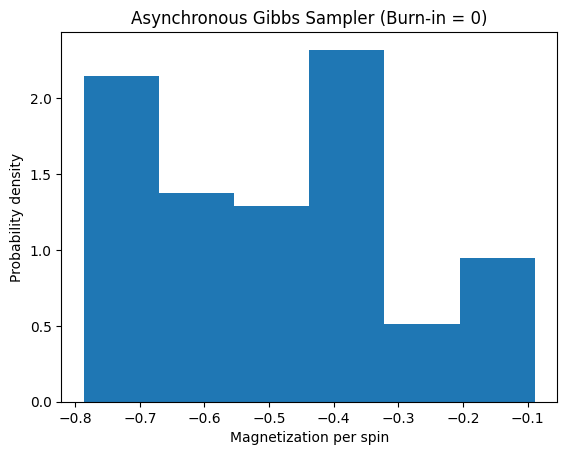

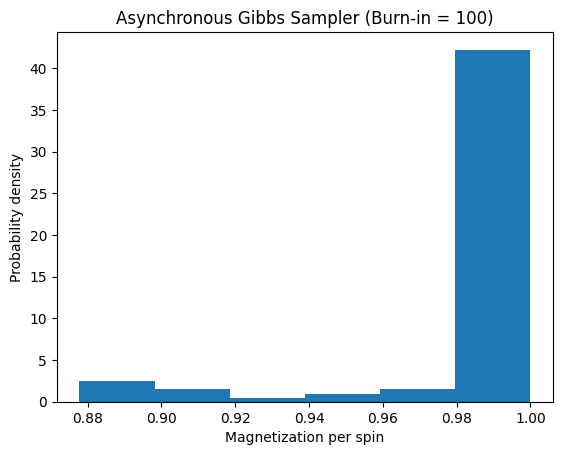

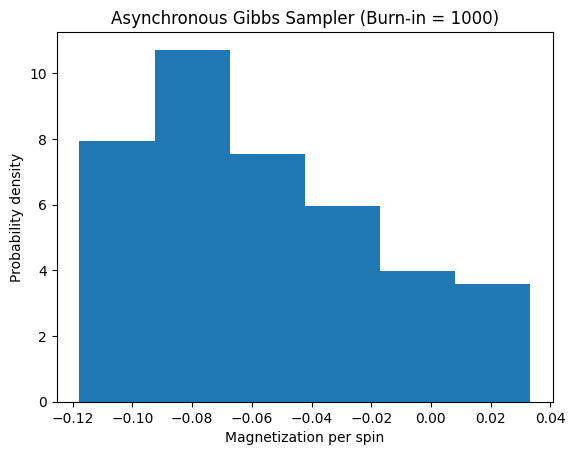

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def initial_config(L):
    """
    Generate a random initial configuration of spins (+1 or -1).
    """
    return np.random.choice([-1, 1], size=(L, L))

def gibbs_sampler_async(config, beta, J, B, num_sweeps):

    L = config.shape[0]
    for sweep in range(num_sweeps):
        # Create a list of all indices and shuffle it
        indices = [(i, j) for i in range(L) for j in range(L)]
        np.random.shuffle(indices)
        for (i, j) in indices:
            # Periodic boundaries (neighbors at up, down, left, right)
            s_neighbors = (config[(i+1)%L, j] + config[(i-1)%L, j] +
                           config[i, (j+1)%L] + config[i, (j-1)%L])
            # Conditional probability for spin (i,j) being +1:
            # P(S=+1) = 1 / (1 + exp(-2β (J*s_neighbors + B)))
            p = 1.0 / (1 + np.exp(-2 * beta * (J * s_neighbors + B)))
            config[i, j] = 1 if np.random.rand() < p else -1
        yield config.copy()

def magnetization(config):
    return np.sum(config) / config.size

# Parameters for Gibbs sampling
L = 30
J = 1
B = 0
T = 1.0
beta = 1.0 / T
num_sweeps = 200

for burn_in in [0, 100, 1000]:
    config = initial_config(L)
    mags = []
    sampler = gibbs_sampler_async(config, beta, J, B, num_sweeps + burn_in)
    for _ in range(burn_in):
        next(sampler)
    for _ in range(100):
        conf = next(sampler)
        mags.append(magnetization(conf))
    plt.hist(mags, bins=6, density=True)
    plt.xlabel('Magnetization per spin')
    plt.ylabel('Probability density')
    plt.title(f'Asynchronous Gibbs Sampler (Burn-in = {burn_in})')
    plt.show()
